<a href="https://colab.research.google.com/github/MadushanPathirana/msc-research/blob/main/adaptive_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.0 MB/s eta 0:00:00



## Paddin wih LSTM resource and other resources


* https://gist.github.com/HarshTrivedi/f4e7293e941b17d19058f6fb90ab0fec

* https://discuss.pytorch.org/t/trouble-with-packed-padded-sequence-and-lstm-for-variable-length-inputs/50028

* https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

* https://colab.research.google.com/drive/1jDiuseAdtZCYbAX2IRv2HU8zG5585bRi?usp=sharing

In [421]:
import random
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt;
np.random.seed(42);
from sklearn.metrics import roc_auc_score;
import urllib.request
from tqdm import tqdm
from datetime import datetime

import torch_geometric as pyg
from torch_geometric.nn import GCNConv, GATConv, SAGEConv
#from torch_geometric.nn import  to_hetero ,LSTMAggregation
import  torch.nn as nn
import torch.nn.functional as F
import torch
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData,Data
import torch
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.utils.rnn as rnn_utils

In [3]:
def time_difference(start_time):
  """
  Calculates the time difference between the current time and a given starting time.

  Args:
    start_time: A datetime object representing the starting time.

  Returns:
    A timedelta object representing the time difference between the current time and the starting time.
  """

  current_time = datetime.now()
  time_diff = current_time - start_time
  return time_diff.seconds /60



In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
  print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))
else:
  print(device.type)

cpu


# Configurations


In [892]:
batch_size = 24 # number of users per batch
block_size = 3 # sequnce lenght
train_split = .82
skill_embd_dim = 256
num_epochs = 10
num_LSTM_layers = 1
hidden_size = 300
lr = 0.0005
wd = 1e-10

out_channels=1

### good combination of configurations
**Config 1**
-----------

* batch_size = 32
* block_size = 10
* train_split = .82
* skill_embd_dim = 120
* num_epochs = 10
* num_LSTM_layers = 1
* hidden_size = 100
* out_channels=1 , 2 GNN hidden layers , Graphsage model

**Config 2**
-----------

* batch_size = 24 # number of users per batch
* block_size = 3 # sequnce lenght
* train_split = .82
* skill_embd_dim = 256
* num_epochs = 10
* num_LSTM_layers = 1
* hidden_size = 300
* lr = 0.0005
* wd = 1e-10
* out_channels=1 , 3  GNN layers , GAT model

# Read data

In [864]:
#df = pd.read_pickle('https://github.com/MadushanPathirana/msc-research/raw/main/adaptive%20learning/creating%20graph/working_model/dfUsers.pickle')
#url_df="https://raw.githubusercontent.com/MadushanPathirana/msc-research/main/adaptive%20learning/creating%20graph/working_model/df_13.csv"


#df = pd.read_csv(url_df)
df = pd.read_pickle('https://github.com/MadushanPathirana/msc-research/raw/main/adaptive%20learning/creating%20graph/working_model/dfUsers.pickle')

users_to_drop = df.groupby('user_id')['interaction_end_time'].nunique()[df.groupby('user_id')['interaction_end_time'].nunique()<block_size+1].index.tolist()
df= df[~df.user_id.isin( users_to_drop)]

# Download the file locally
url = 'https://github.com/MadushanPathirana/msc-research/raw/main/adaptive%20learning/creating%20graph/working_model/df2.pickle'
urllib.request.urlretrieve(url, 'df2.pickle')

# Load the local pickle file
df2 = pd.read_pickle('df2.pickle')


In [865]:
df.user_id.nunique()

321

# Preprocessing data


In [866]:
def preprocess_data(data):
    """
    Pre-process data and pad to the maximum length.
    """
    #features = ['loIndex', 'atomIndex','correctBinary']
    features = ['loIndex','correctBinary']
    seqs = data.groupby(['user_id']).apply(lambda x: x[features].values.tolist())
    # ensure sequence is not too long
    length = min(max(seqs.str.len()), block_size)
    seqs = seqs.apply(lambda s: s[:length] + (length - min(len(s), length)) * [[-1000] * len(features)])
    return seqs


def process_dataframe(df,df2,loGraphID):
  atom_index={atom_id:i for i,atom_id  in  enumerate(df.atom_id.unique())}

  df['atomIndex']=df.atom_id.map(atom_index)
  lo_map=pd.concat([df2[df2['graph_id']==loGraphID][['source_lo_title','source_index']].rename(columns={'source_lo_title':'learning_objective_name','source_index':'loIndex'}),
                      df2[df2['graph_id']==loGraphID][['dest_lo_title','dest_index']].rename(columns={'dest_lo_title':'learning_objective_name','dest_index':'loIndex'})]).drop_duplicates().reset_index(drop=True)
  #print(lo_map)
  df3=df.merge(lo_map,on='learning_objective_name',how='left')
  return df3

def train_test_split(df):
    """
    Performs a deterministic train-test split based on the tabular data provided.
    Note that this function needs to be called twice to perform a train-val-test
    split as desired.

    Arguments:
      - data: tabular KT dataset (pd.DataFrame)

    Returns:
      - data_train: training dataset
      - data_val: validation/testing dataset
    """
    loGraphID = df.loGraphID.unique()[0]
    data= process_dataframe(df,df2,loGraphID)
    np.random.seed(42)
    #data = data.set_index(['user_id', 'loIndex'])
    data = data.set_index('user_id')
    idx = np.random.permutation(data.index.unique())
    train_idx, test_idx = idx[:int(train_split * len(idx))], idx[int(train_split * len(idx)):]
    data_train = data.loc[train_idx].reset_index()
    data_val = data.loc[test_idx].reset_index()
    return data_train, data_val

def construct_batches(raw_data, epoch = 0, val = False):
    """
    Construct batches based on tabular KT data with user_id, skill_id, and
    correctness. Pads to the minimum of the maximum sequence length and the
    block size of the transformer.
    """
    np.random.seed(epoch)
    user_ids = raw_data['user_id'].unique()

    # Loop until one epoch of training.
    for _ in range(len(user_ids) // batch_size):
        user_idx = raw_data['user_id'].sample(batch_size).unique() if not val else user_ids[_ * (batch_size // 2): (_ + 1) * (batch_size // 2)]
        filtered_data = raw_data[raw_data['user_id'].isin(user_idx)].sort_values(['user_id', 'interaction_end_time'])
        batch_preprocessed = preprocess_data(filtered_data)
        batch = np.array(batch_preprocessed.to_list())


        X = torch.tensor(batch[:, :, ..., :], requires_grad=True, dtype=torch.float32).to(device)
        y = torch.tensor(batch[:, :, ..., [-1]], requires_grad=True, dtype=torch.float32).to(device)
        #print(X.shape,y.shape)
        for i in range(X.shape[1] // block_size + 1):
            #print(X[:, i * block_size: (i + 1) * block_size].shape)
            if X[:, i * block_size: (i + 1) * block_size].shape[1] > 0:
                yield [X[:, i * block_size: (i + 1) * block_size], y[:, i * block_size: (i + 1) * block_size]]

def create_graph(df2,loGraphID):

  lo_edges = df2[df2['graph_id']==loGraphID][['source_index','dest_index']].values.transpose()

  lo_edges = torch.from_numpy(lo_edges).long().to(device)

  graph = Data(edge_index=lo_edges)


  return graph


# GNN Models


## GraphSAGE

In [867]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, num_skills, num_layers = 3, hidden_dim = skill_embd_dim):
        """
        Represents a GraphSAGE graph neural network with num_layers
        layers and embedding and hidden dimension of hidden_dim.
        """
        super().__init__()
        self.tag = 'GraphSAGE'
        self.pre_embs = nn.Embedding(num_skills, hidden_dim)
        self.conv1 = SAGEConv(hidden_dim, hidden_dim)
        self.prelu1 = nn.PReLU()
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.prelu2 = nn.PReLU()
        self.conv3 = SAGEConv(hidden_dim, hidden_dim)
        self.prelu3 = nn.PReLU()
        self.conv4 = SAGEConv(hidden_dim, hidden_dim)
        self.prelu4 = nn.PReLU()
        self.out = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, edge_index):
        """
        Runs a forward pass through GraphSAGE with given initial skill IDs and
        edge_index and edge_weights.

        Arguments:
          - x: skill IDs (torch.Tensor)
          - edge_index: edges in skill graph (torch.Tensor)
          - edge_weight: edge weights of skill graph (torch.Tensor)

        Returns:
          - final node embedding for skill
        """
        h0 = self.pre_embs(x) # initial skill embedding
        h1 = self.dropout(self.prelu1(self.conv1(h0, edge_index)))
        h2 = self.dropout(self.prelu2(self.conv2(h1, edge_index)))
        h3 = self.dropout(self.prelu2(self.conv3(h1, edge_index)))
        h4 = self.prelu3(self.conv4(h3, edge_index))
        return self.out(h4)

## GCN

In [868]:
class GCN(torch.nn.Module):
    def __init__(self, num_skills, num_layers = 3, hidden_dim = skill_embd_dim):
        """
        Represents a simple Graph Convolutional Network (GCN) with num_layers
        layers and embedding and hidden dimension of hidden_dim.
        """
        super().__init__()
        self.tag = 'GCN'
        self.pre_embs = nn.Embedding(num_skills, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.prelu1 = nn.PReLU()
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.prelu2 = nn.PReLU()
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.prelu3 = nn.PReLU()
        self.out = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        """
        Runs a forward pass through the GCN with given initial skill IDs and
        edge_index and edge_weights.

        Arguments:
          - x: skill IDs (torch.Tensor)
          - edge_index: edges in skill graph (torch.Tensor)
          - edge_weight: edge weights of skill graph (torch.Tensor)

        Returns:
          - final node embedding for skill
        """
        h0 = self.pre_embs(x) # initial skill embedding
        h1 = self.dropout(self.prelu1(self.conv1(h0, edge_index)))
        h2 = self.dropout(self.prelu2(self.conv2(h1, edge_index)))
        h3 = self.prelu3(self.conv3(h2, edge_index))
        return self.out(h3)

## GAT

In [869]:
class GAT(torch.nn.Module):
    def __init__(self, num_skills, num_layers = 3, hidden_dim = skill_embd_dim):
        """
        Represents a Graph Attention Network (GAT) with num_layers
        layers and embedding and hidden dimension of hidden_dim.
        """
        super().__init__()
        self.tag = 'GAT'
        self.pre_embs = nn.Embedding(num_skills, hidden_dim)
        self.conv1 = GATConv(hidden_dim, hidden_dim)
        self.prelu1 = nn.PReLU()
        self.conv2 = GATConv(hidden_dim, hidden_dim)
        self.prelu2 = nn.PReLU()
        self.conv3 = GATConv(hidden_dim, hidden_dim)
        self.prelu3 = nn.PReLU()
        self.out = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, edge_index):
        """
        Runs a forward pass through GAT with given initial skill IDs and
        edge_index and edge_weights.

        Arguments:
          - x: skill IDs (torch.Tensor)
          - edge_index: edges in skill graph (torch.Tensor)
          - edge_weight: edge weights of skill graph (torch.Tensor)

        Returns:
          - final node embedding for skill
        """
        h1 = self.dropout(self.prelu1(self.conv1(self.pre_embs(x), edge_index)))
        h2 = self.dropout(self.prelu2(self.conv2(h1, edge_index)))
        h3 = self.prelu3(self.conv3(h2, edge_index))
        return self.out(h3)

# LSTM Model

In [870]:



class LSTM(nn.Module):

    def __init__(self ):
        super().__init__()
        self.num_layers = num_LSTM_layers # number of recurrent layers in the lstm
        self.input_size = skill_embd_dim # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        self.sigmoid=nn.Sigmoid()

        self.lstm = nn.LSTM(
            input_size=self.input_size ,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True,dropout=.2
        )
        self.fc = nn.Linear(hidden_size, 1)


    def forward(self,x):

        h0 = torch.zeros(self.lstm.num_layers, x.data.size(0), self.hidden_size).requires_grad_().to(device)
        # Initialize long-term memory
        c0 = torch.zeros(self.lstm.num_layers, x.data.size(0), self.hidden_size).requires_grad_().to(device)
        # Pass all inputs to lstm layer
        out, (hn0, cn0) = self.lstm(x, (h0, c0))

        #unpack padded sequnce
        unpacked, unpacked_len = torch.nn.utils.rnn.pad_packed_sequence(out,batch_first=True)

        #print(out.shape)
        out = self.sigmoid( self.fc(unpacked))
        #out = self.sigmoid( self.fc(hn0))
        return out

# Classifier

In [871]:
class Classifer(nn.Module):
  def __init__(self,num_skills):
    super().__init__()
    self.num_skills=num_skills
    self.LSTM = LSTM()
    #self.gnn = GraphSAGE(self.num_skills)
    #self.gnn = GCN(self.num_skills)
    self.gnn = GAT(self.num_skills)
    self.bn  = nn.BatchNorm1d(block_size)
  def forward(self,skill_grpah ,X ):
    all_skill_embd  = self.gnn(torch.arange(self.num_skills).to(device), skill_grpah.edge_index)

    skill_embd = all_skill_embd[torch.where(X[..., 0] == -1000, 0 , X[..., 0]).long()]

    #skill_embd[X[..., 0] == -1000] = 0

    mask = (X[:,:,0] != -1000).float()

    # Calculating sequence length for each batch
    sequence_lengths = mask.sum(dim=1).long()

    skill_embd_packed = rnn_utils.pack_padded_sequence(skill_embd, sequence_lengths, batch_first=True, enforce_sorted=False)


    #skill_embd = self.bn(skill_embd)
    #out =  self.LSTM(skill_embd)
    out = self.LSTM( skill_embd_packed)
    return out



# Init model

In [893]:


def init_model(loGraphID,num_skills):

  model = Classifer(num_skills)
  model.to(device)
  data_train, data_test = train_test_split(df)
  skill_grpah =  create_graph(df2,loGraphID)
  skill_grpah.to(device)

  optimizer=torch.optim.Adam(model.parameters(),lr=lr,weight_decay=wd )

  return model, data_train , data_test , skill_grpah , optimizer



# Train and Test

In [873]:
def model_perfomance(model,outputs, ytrue,y ):

  model.eval()
  mask = y[..., -1] != -1000
  accuracy = np.mean(np.round(outputs)==ytrue)



  roc_auc = roc_auc_score(ytrue, outputs)
  return accuracy ,roc_auc

In [898]:
def test(model,data_test,skill_grpah,epoch,optimizer):
  model.eval()
  with torch.no_grad():
    losses=[]
    batches_train = construct_batches(data_test,epoch = epoch,val = True)
    pbar = iter(batches_train)
    outputs= []
    ytrue = []
    for X, y in pbar:


      optimizer.zero_grad()
      output = model(skill_grpah,X)
      mask = y[..., -1] != -1000


      loss=F.binary_cross_entropy(output[mask], y[..., -1:][mask])

      outputs.extend(output[mask].ravel().detach().tolist())
      ytrue.extend(y[..., -1:][mask].ravel().detach().tolist())
      losses.append(loss.item())
    accuracy ,roc_auc = model_perfomance(model , outputs, ytrue,y)
    print(f'Test ->     loss : {np.mean(losses) :.5f} , accuracy : {accuracy : .2%} , roc_auc {roc_auc : .2%} \n')

    return np.mean(losses) ,accuracy ,roc_auc

In [895]:
def results(train_losses,test_losses,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc):
  fig,axs=plt.subplots(1,3,figsize=(18,7))
  x_ticks = np.arange(0,len(train_losses),2)
  axs[0].plot(train_losses, label = 'train')
  axs[0].plot(test_losses, label = 'test')
  axs[0].set_ylabel('loss')
  axs[0].legend()
  axs[0].set_xticks(x_ticks,x_ticks)
  axs[0].grid()

  axs[1].plot(train_accuracy, label = 'train')
  axs[1].plot(test_accuracy, label = 'test')
  axs[1].set_ylabel('accuracy')
  axs[1].legend()
  axs[1].set_xticks(x_ticks,x_ticks)
  axs[1].grid()

  axs[2].plot(train_roc_auc, label = 'train')
  axs[2].plot(test_roc_auc, label = 'test')
  axs[2].set_ylabel('roc_auc')
  axs[2].legend()
  axs[2].set_xticks(x_ticks,x_ticks)
  axs[2].grid()

  plt.tight_layout()



In [896]:

def train(epoches):
  num_skills = df.learning_objective_name.nunique()
  print(num_skills)
  graph_id = df.loGraphID.unique()[0]
  model, data_train , data_test , skill_grpah , optimizer =  init_model(graph_id,num_skills)
  print(skill_grpah)
  train_losses =[]
  test_losses = []

  train_accuracy = []
  test_accuracy = []

  train_roc_auc = []
  test_roc_auc = []

  for epoch in range(epoches):
    model.train()
    losses=[]
    batches_train = construct_batches(data_train,epoch = epoch)
    pbar = iter(batches_train)
    outputs= []
    ytrue = []

    for X, y in pbar:
      #print(X.shape,y.shape)

      optimizer.zero_grad()
      output = model(skill_grpah,X)
      mask = y[..., -1] != -1000


      loss = F.binary_cross_entropy(output[mask], y[..., -1:][mask])
      loss.backward()
      optimizer.step()
      losses.append(loss.item())
      outputs.extend(output[mask].ravel().detach().tolist())
      ytrue.extend(y[..., -1:][mask].ravel().detach().tolist())

    train_acc ,train_roc_acu_score = model_perfomance(model , outputs, ytrue,y)
    train_loss = np.mean(losses)
    print(train_loss)
    print(f'epoch : {epoch} , loss : {np.mean(losses) :.5f} , accuracy : {train_acc : .2%} , roc_acu {train_roc_acu_score :.2%}')
    test_loss, test_acc,test_roc_auc_score =test(model,data_test,skill_grpah,epoch,optimizer)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)

    train_roc_auc.append(train_roc_acu_score)
    test_roc_auc.append(test_roc_auc_score)

  results(train_losses, test_losses,
          train_accuracy, test_accuracy,
          train_roc_auc,test_roc_auc)



# Results

31


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Data(edge_index=[2, 41])
0.5843129634857178
epoch : 0 , loss : 0.58431 , accuracy :  74.65% , roc_acu 58.99%
Test ->   loss : 0.61876 , accuracy :  79.17% , roc_auc  49.81% 

0.5443034827709198
epoch : 1 , loss : 0.54430 , accuracy :  76.45% , roc_acu 62.50%
Test ->   loss : 0.53896 , accuracy :  79.17% , roc_auc  49.81% 

0.49800564646720885
epoch : 2 , loss : 0.49801 , accuracy :  77.68% , roc_acu 65.26%
Test ->   loss : 0.53836 , accuracy :  79.17% , roc_auc  72.79% 

0.5428112030029297
epoch : 3 , loss : 0.54281 , accuracy :  74.01% , roc_acu 61.32%
Test ->   loss : 0.51777 , accuracy :  79.17% , roc_auc  77.16% 

0.535292112827301
epoch : 4 , loss : 0.53529 , accuracy :  74.92% , roc_acu 65.70%
Test ->   loss : 0.51161 , accuracy :  79.17% , roc_auc  73.08% 

0.4886451154947281
epoch : 5 , loss : 0.48865 , accuracy :  78.55% , roc_acu 66.16%
Test ->   loss : 0.52427 , accuracy :  79.17% , roc_auc  77.21% 

0.5089149236679077
epoch : 6 , loss : 0.50891 , accuracy :  76.73% , roc_ac

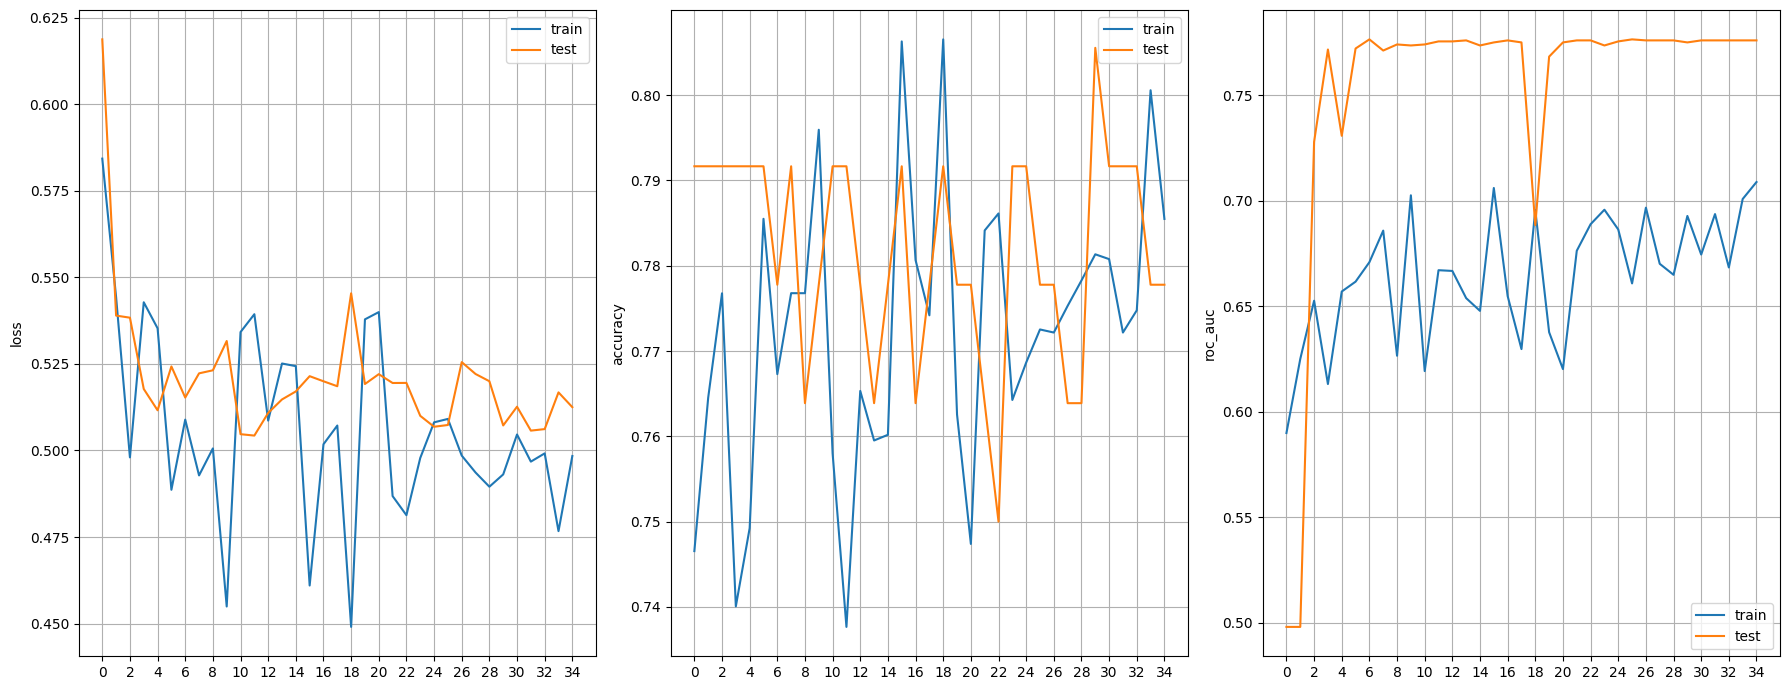

In [897]:
train(35)

In [878]:
train_data,test_data=train_test_split(df)

<Axes: >

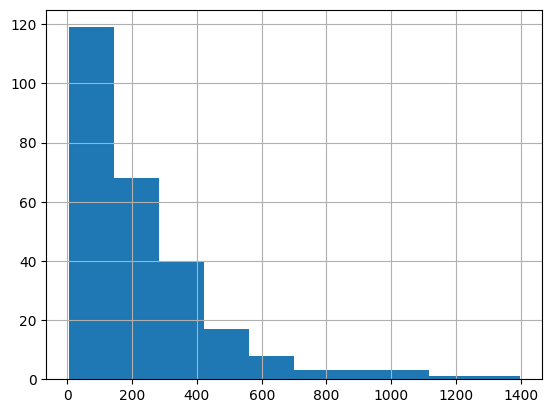

In [879]:
train_data.groupby('user_id')['correct'].count().hist()

<Axes: >

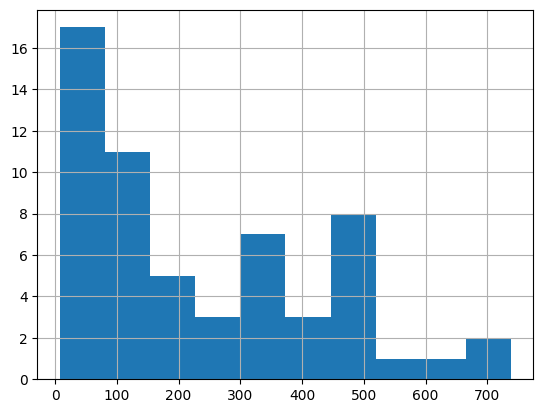

In [880]:
test_data.groupby('user_id')['correct'].count().hist()